In [1]:
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

from best_utils import *
from cross_validation import cross_validation
import image_preprocessing

from skimage import color

import keras

from skimage.color import rgb2hsv

from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, LeakyReLU, Dropout

Using TensorFlow backend.


In [2]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'
GT_DIR = ROOT_DIR + 'groundtruth/'

PATCH_SIZE = 10

In [3]:
# Read images, change to hsv, saturate and stack into a tensor
files = os.listdir(IMAGE_DIR)

imgs = np.stack([load_image(IMAGE_DIR + file) for file in files]) # images (400, 400, 3)
gt_imgs = np.stack([load_image(GT_DIR + file) for file in files]) # images (400, 400)

patched_imgs = np.stack([patch_image(img, PATCH_SIZE) for img in imgs]) # images (400, 400)
patched_gts = np.stack([patch_groundtruth(gt, PATCH_SIZE) for gt in gt_imgs])

In [4]:
PATCHED_SIZE = imgs.shape[1] // PATCH_SIZE
WINDOW_SIZE = 71
WINDOWS_PER_IMAGE = PATCHED_SIZE ** 2

In [5]:
N = 1 # Number of image to be used in training

leakyness = 0.1

In [6]:
windows_per_image = [image_to_features(im, WINDOW_SIZE, True) for im in patched_imgs[:N]]
windows = np.vstack(windows_per_image)

window_labels = np.ravel(patched_gts[:N])
assert window_labels.shape[0] == windows.shape[0]

In [7]:
window_labels.shape

(1600,)

In [8]:
window_labels = keras.utils.np_utils.to_categorical(window_labels)

In [9]:
window_cnn = keras.models.Sequential([
    
    Conv2D(32, (5, 5), strides=(1, 1), input_shape=windows.shape[1:]),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    Dropout(0.25),

    Conv2D(64, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),

    MaxPooling2D(2),
    Dropout(0.25),
    
    Dense(128),
    LeakyReLU(leakyness),
    
    Flatten(),
    Dense(2, activation='sigmoid'),
    #LeakyReLU(leakyness),
])

In [10]:
#window_cnn.summary()

In [60]:
window_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [61]:
nw = windows.shape[0]
def batch_generator():
    while True:
        indices = np.random.choice(range(nw), 200, replace=False)
        yield (windows[indices], window_labels[indices])

In [62]:
def smart_generator(n_windows, n_epochs):
    ws_per_epoch = n_windows // n_epochs
    indices = np.random.choice(range(n_windows), n_epochs*ws_per_epoch, replace=False)
    indices_per_epoch = [indices[i:i+ws_per_epoch] for i in range(0, n_windows, ws_per_epoch)]
    for batch_idx in indices_per_epoch:
        ws = windows[batch_idx]
        labs = window_labels[batch_idx]
        yield (ws, labs)

In [63]:
epochs = 10

In [64]:
start = time.perf_counter()

window_cnn.fit(windows, window_labels, epochs=epochs)#, batch_size=1600)
#window_cnn.fit_generator(smart_generator(windows.shape[0], epochs), steps_per_epoch=windows.shape[0] // epochs, epochs=10)

time.perf_counter() - start

Epoch 1/10
1600/1600 [==============================] - 14s - loss: 0.6089 - acc: 0.7150    
Epoch 2/10
1600/1600 [==============================] - 14s - loss: 0.5992 - acc: 0.7150    
Epoch 3/10
1600/1600 [==============================] - 14s - loss: 0.5441 - acc: 0.7269    
Epoch 4/10
1600/1600 [==============================] - 14s - loss: 0.3667 - acc: 0.8475    
Epoch 5/10
1600/1600 [==============================] - 14s - loss: 0.2640 - acc: 0.8750    
Epoch 6/10
1600/1600 [==============================] - 15s - loss: 0.1747 - acc: 0.9094    
Epoch 7/10
1600/1600 [==============================] - 15s - loss: 0.1814 - acc: 0.9094    
Epoch 8/10
1600/1600 [==============================] - 14s - loss: 0.1339 - acc: 0.9281    
Epoch 9/10
1600/1600 [==============================] - 14s - loss: 0.1219 - acc: 0.9338    
Epoch 10/10
1600/1600 [==============================] - 14s - loss: 0.1213 - acc: 0.9394    


147.78969130601035

In [77]:
#window_cnn.save('backup')

# Test on a never seen image

In [66]:
i = 0

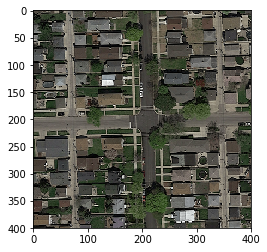

In [67]:
plt.imshow(imgs[i])

In [68]:
window_t = image_to_features(patched_imgs[i], WINDOW_SIZE, True)

In [69]:
window_t.shape

(1600, 71, 71, 3)

In [70]:
preds = window_cnn.predict(window_t)

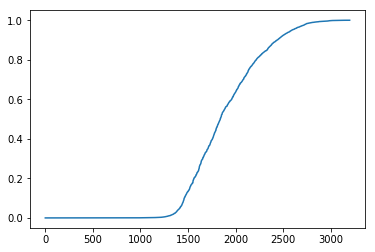

In [71]:
plt.plot(np.sort(np.ravel(preds)))

In [72]:
preds = (preds[:,1] > preds[:,0]) * 1

In [73]:
f = preds
f = np.reshape(f, (PATCHED_SIZE, PATCHED_SIZE))

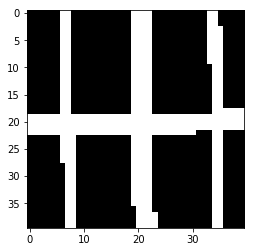

In [74]:
plt.imshow(patched_gts[i], cmap='Greys_r')

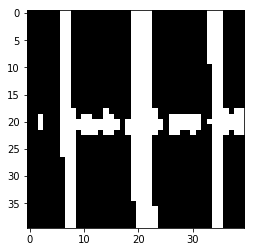

In [75]:
plt.imshow(f, cmap='Greys_r')

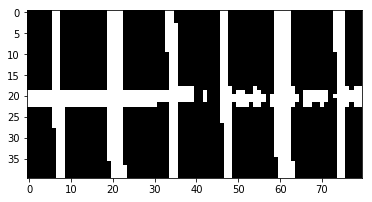

In [76]:
plt.imshow(np.hstack([patched_gts[i], f]), cmap='Greys_r')

# Test data set

In [ ]:
TEST_DIR = 'test_set_images/'
test_files = os.listdir(TEST_DIR)

test_imgs = [load_image(TEST_DIR + file + '/' + file + '.png') for file in test_files]

In [ ]:
patched_tests = np.stack([patch_image(im, PATCH_SIZE) for im in test_imgs])

In [ ]:
test_windows = np.vstack([image_to_features(im, WINDOW_SIZE, True) for im in patched_imgs])

In [ ]:
test_windows.shape

In [ ]:
predictions = window_cnn.predict(test_windows)